# Notebook for Dev of GammaFactor Metric 

In [1]:
import numpy as np

from brian2 import *
from brian2tools import *

INFO       Cache size for target "cython": 1005 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Re-use code from old ModelFitting version

In [2]:
def firing_rate(spikes):
    '''
    Rate of the spike train.
    '''
    if len(spikes)<2:
        return NaN
    return (len(spikes) - 1) / (spikes[-1] - spikes[0])

## Generate Two Spike Trains with IF

In [3]:
dt = 0.01 * ms
defaultclock.dt = dt
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)*5), np.zeros(5*int(5*ms/dt))])* 5 * nA

In [4]:
# C = 1*nF
# gL = 30*nS
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

In [5]:
start_scope()

In [6]:
I = TimedArray(input_current, dt=dt)

In [7]:
group = NeuronGroup(2, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')

In [8]:
group.v = -70 *mV

In [9]:
group.set_states({'gL': [30*nS, 30*nS], 'C':[1*nF, 2*nF]})
group.get_states()

{'N': array(2),
 'i': array([0, 1], dtype=int32),
 't': 0. * second,
 'dt': 10. * usecond,
 't_in_timesteps': array(0),
 'v': array([-70., -70.]) * mvolt,
 'gL': array([30., 30.]) * nsiemens,
 'C': array([1., 2.]) * nfarad}

In [10]:
monitor = StateMonitor(group, 'v', record=True)
smonitor  = SpikeMonitor(group)

In [11]:
run(60*ms)

In [12]:
voltage = monitor.v[0]/mV
voltage1 = monitor.v[1]/mV

In [13]:
spike_times = smonitor.t_[:]

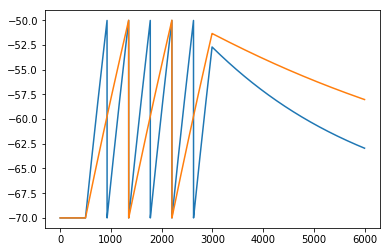

In [14]:
plot(voltage);
plot(voltage1);

### Get Spike Information

In [15]:
smonitor.i[:]

array([0, 0, 1, 0, 0, 1, 0], dtype=int32)

In [16]:
smonitor.num_spikes

7

In [17]:
 smonitor.all_values()

{'t': {0: array([ 9.24, 13.5 , 17.76, 22.02, 26.28]) * msecond,
  1: array([13.5 , 22.02]) * msecond}}

In [36]:
smonitor.values('t')

{0: array([ 9.24, 13.5 , 17.76, 22.02, 26.28]) * msecond,
 1: array([13.5 , 22.02]) * msecond}

In [40]:
smonitor.values('t')[0]/ms

array([ 9.24, 13.5 , 17.76, 22.02, 26.28])

In [41]:
smonitor.values('t')[1]/ms

array([13.5 , 22.02])

In [19]:
smonitor.spike_trains()

{0: array([ 9.24, 13.5 , 17.76, 22.02, 26.28]) * msecond,
 1: array([13.5 , 22.02]) * msecond}

In [37]:
getattr(smonitor, 't')

In [38]:
smonitor.i[:]

array([0, 0, 1, 0, 0, 1, 0], dtype=int32)

### Separate the Traces

In [21]:
spike_trains = smonitor.spike_trains()
spike_trains

{0: array([ 9.24, 13.5 , 17.76, 22.02, 26.28]) * msecond,
 1: array([13.5 , 22.02]) * msecond}

In [22]:
st0 = spike_trains[0] / ms
st0

array([ 9.24, 13.5 , 17.76, 22.02, 26.28])

In [23]:
st1 = spike_trains[1] / ms
st1

array([13.5 , 22.02])

In [24]:
print(len(st1))
print(len(st0))

2
5


In [25]:
fr0 = firing_rate(st0)
fr0

0.2347417840375587

In [26]:
fr1 = firing_rate(st1)
fr1

0.11737089201877937

## Gamma Factor with Big window

In [27]:
delta = 60 * ms

In [28]:
source = array(st1)
target = array(st0)
target_rate = firing_rate(target) * Hz

source = np.array(np.rint(source / dt), dtype=int)
target = np.array(np.rint(target / dt), dtype=int)
delta_diff = int(np.rint(delta / dt))

source_length = len(source)
target_length = len(target)

if (source_length > 1):
    bins = .5 * (source[1:] + source[:-1])
    indices = np.digitize(target, bins)
    diff = np.abs(target - source[indices])
    matched_spikes = (diff <= delta_diff)
    coincidences = np.sum(matched_spikes)
else:
    indices = [np.amin(np.abs(source - target[i])) <= delta_diff for i in xrange(target_length)]
    coincidences = np.sum(indices)

# Normalization of the coincidences count
NCoincAvg = 2 * delta * target_length * target_rate
norm = .5*(1 - 2 * target_rate * delta)
gamma = (coincidences - NCoincAvg)/(norm*(source_length + target_length))

In [29]:
gamma

0.5465838509316769

In [30]:
def get_gamma_factor(source, target, delta, dt):
    source = array(source)
    target = array(target)
    target_rate = firing_rate(target) * Hz

    source = np.array(np.rint(source / dt), dtype=int)
    target = np.array(np.rint(target / dt), dtype=int)
    delta_diff = int(np.rint(delta / dt))

    source_length = len(source)
    target_length = len(target)

    if (source_length > 1):
        bins = .5 * (source[1:] + source[:-1])
        indices = np.digitize(target, bins)
        diff = np.abs(target - source[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = np.sum(matched_spikes)
    else:
        indices = [np.amin(np.abs(source - target[i])) <= delta_diff for i in xrange(target_length)]
        coincidences = np.sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * target_length * target_rate
    norm = .5*(1 - 2 * target_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(source_length + target_length))
    
    return gamma

In [31]:
get_gamma_factor(st1, st0, 100*ms, 0.01*ms)

0.5292047853624208